In [21]:
import numpy as np
import scipy.io.wavfile as wf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import IPython.display

# Introduction
- ICA = independent component analysis
- try ICA
- ref:
    - https://www.hellocybernetics.tech/entry/2016/05/21/185705#BSSの解法独立成分分析  
    - https://blog.aidemy.net/entry/2018/04/07/003102

# Prepare Data

## read data

In [8]:
path1 = './03_ICA/loop1.wav'
path2 = './03_ICA/strings.wav'

In [12]:
rate1, data1 = wf.read(path1)
rate2, data2 = wf.read(path2)
print('rate1:', rate1)
print('rate2:', rate2)

rate1: 44100
rate2: 44100


## EDA

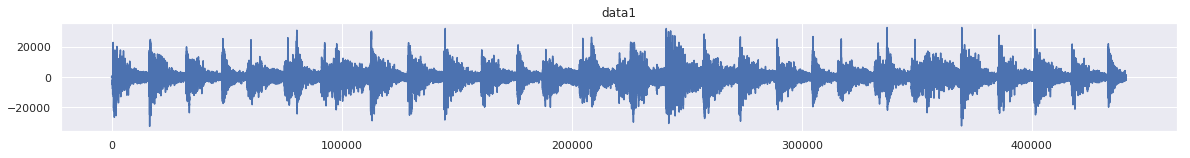

In [27]:
fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(data1)
ax.set_title("data1")
IPython.display.display(IPython.display.Audio(data1, rate=rate1))

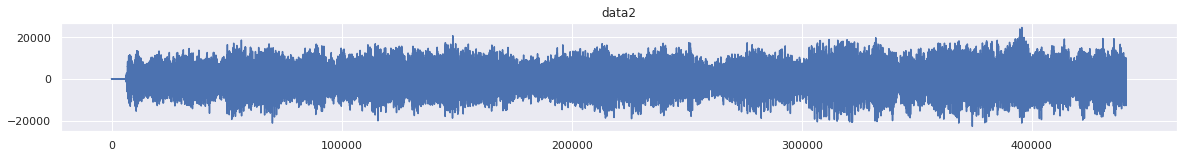

In [24]:
fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(data2)
ax.set_title("data2")
IPython.display.display(IPython.display.Audio(data2, rate=rate2))

# Try ICA

## mix data
- 簡単なICA は 分けたい音源の数=チャンネル数 である
- 今回は、二つの音源を分離するため、マイクの数を2つ使って集音したことにする(2ch)

In [38]:
mix_1 = data1 * 0.6 + data2 * 0.4
mix_2 = data1 * 0.2 + data2 * 0.8

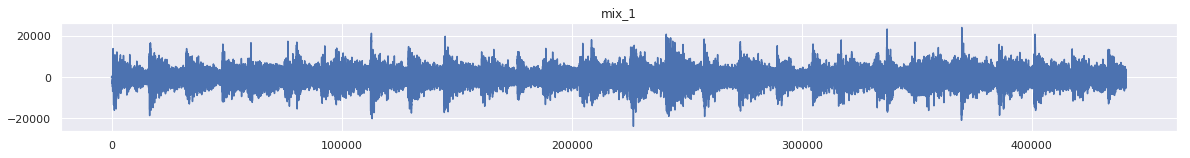

In [39]:
fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(mix_1)
ax.set_title("mix_1")
IPython.display.display(IPython.display.Audio(mix_1, rate=rate1))

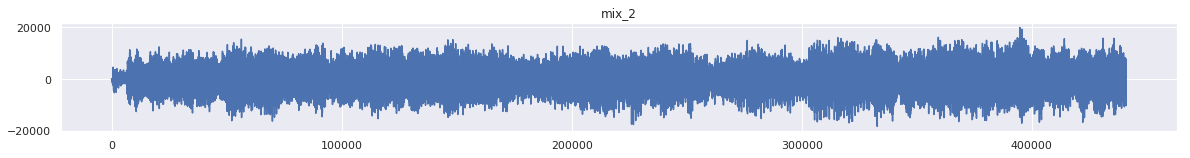

In [30]:
fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(mix_2)
ax.set_title("mix_2")
IPython.display.display(IPython.display.Audio(mix_2, rate=rate1))

# Do ICA

**def class**

In [40]:
epsilon = 1e-5

class ICA:
    def __init__(self, x):
        self.x = np.matrix(x)

    def ica(self): #独立成分分析
        self.fit()
        z = self.whiten()
        y = self.analyze(z)
        return y

    def fit(self): #平均を0にする
        self.x -= self.x.mean(axis=1)

    def whiten(self): #白色化
        sigma = np.cov(self.x, rowvar=True, bias=True)
        D, E = np.linalg.eigh(sigma)
        E = np.asmatrix(E)
        Dh = np.diag(np.array(D) ** (-1/2))
        V = E * Dh * E.T
        z = V * self.x
        return z

    def normalize(self, x): #正規化
        if x.sum() < 0:
            x *= -1
        return x / np.linalg.norm(x)

    def analyze(self, z):
        c, r = self.x.shape
        W = np.empty((0, c))
        for _ in range(c): #観測数分だけアルゴリズムを実行する
            vec_w = np.random.rand(c, 1)
            vec_w = self.normalize(vec_w)
            while True:
                vec_w_prev = vec_w
                vec_w = np.asmatrix((np.asarray(z) * np.asarray(vec_w.T * z) ** 3).mean(axis=1)).T - 3 * vec_w
                vec_w = self.normalize(np.linalg.qr(np.asmatrix(np.concatenate((W, vec_w.T), axis=0)).T)[0].T[-1].T) #直交化法と正規化
                if np.linalg.norm(vec_w - vec_w_prev) < epsilon: #収束判定
                    W = np.concatenate((W, vec_w.T), axis=0)
                    break
        y = W * z
        return y


---
**do it**

In [44]:
data = [data1.astype(float), data2.astype(float)]

y = ICA(data).ica()
y = [(y_i * 32767 / max(np.absolute(y_i))).astype(np.int16) for y_i in np.asarray(y)]

---
**listen**

In [45]:
IPython.display.display(IPython.display.Audio(y[0], rate=rate1))
IPython.display.display(IPython.display.Audio(y[1], rate=rate1))